In [2]:
from ChessEngine import *
import pandas as pd
import time
import math

def find_move_benchmark_all(fen: str, search_depth: int, versions: dict[int, str]):
    result_df = pd.DataFrame()

    num_versions = len(versions)
    cols = math.ceil(math.sqrt(num_versions))
    rows = math.ceil(num_versions / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(8 * cols, 8 * rows))

    row, col = 0, 0

    for version, version_discription in versions.items():
        game = ChessGame(fen)
        start = time.time()
        move = find_move(game, search_depth, version=version)
        end = time.time()

        result_df = pd.concat([result_df, pd.DataFrame({
            'Version'        : [version_discription],
            'Execution time' : [end - start],
            'Evaluations'    : [get_evaluation_count()]
        }, index=[version])])

        moves = None if move is None else [move]
        axs[row, col].set_title(version_discription, fontdict={'fontsize': 20, 'fontweight': 'medium'})
        game.plot(moves=moves, ax=axs[row, col] if rows > 1 else axs[col])
        col += 1
        if col >= cols:
            col = 0
            row += 1

    while row < rows:
        (axs[row, col] if rows > 1 else axs[col]).set_visible(False)
        col += 1
        if col >= cols:
            col = 0
            row += 1

    return result_df

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


,Version,Execution time,Evaluations
0,Sequential,0.207855,1781
1,Sequential + Alpha-beta,0.047496,309
2,Sequential + Alpha-beta + Move sorting,0.027898,118
3,Parallel v1,0.476687,1781
4,Parallel v1 + Alpha-beta,0.083163,1781
5,Parallel v1 + Alpha-beta + Move sorting,0.076989,1781


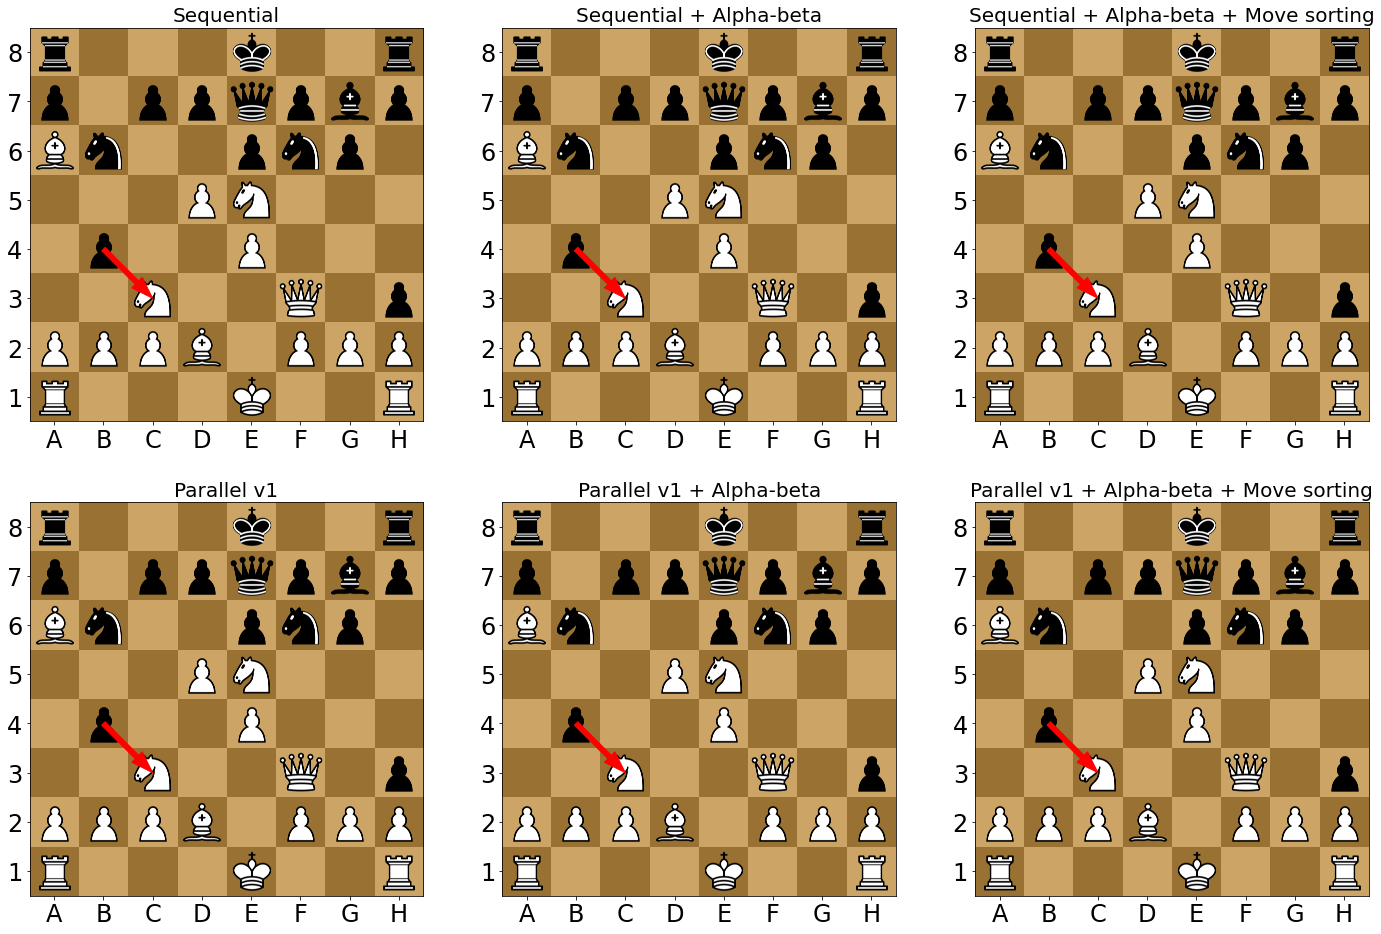

In [3]:
find_move_benchmark_all('r3k2r/p1ppqpbp/Bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPB1PPP/R3K2R b KQkq - 0 1', 2, {
    0: 'Sequential',
    1: 'Sequential + Alpha-beta',
    2: 'Sequential + Alpha-beta + Move sorting',
    3: 'Parallel v1',
    4: 'Parallel v1 + Alpha-beta',
    5: 'Parallel v1 + Alpha-beta + Move sorting'
})